### Preprocess iEEG data

In [2]:
import numpy as np
import mne
import pandas as pd
import mne_bids

from utils import resample, smooth_signal

### Specify subject's directory and meta-information 

In [5]:
bids_dir='/Fridge/users/julia/project_chill_dataset_paper/data/BIDS2'
subjects = mne_bids.get_entity_vals(bids_dir, 'subject')

subject = '01'
acquisition = 'clinical'
task = 'film'
datatype = 'ieeg'
session = 'iemu'

### Load channels

In [6]:
channels_path = mne_bids.BIDSPath(subject=subject,
                                    session=session,
                                    suffix='channels',
                                    extension='tsv',
                                    datatype=datatype,
                                    task=task,
                                    acquisition=acquisition,
                                    root=bids_dir)
channels = pd.read_csv(str(channels_path.match()[0]), sep='\t', header=0, index_col=None)

### Load data information

In [7]:
data_path = mne_bids.BIDSPath(subject=subject,
                                    session=session,
                                    suffix='ieeg',
                                    extension='vhdr',
                                    datatype=datatype,
                                    task=task,
                                    acquisition=acquisition,
                                    root=bids_dir)
raw = mne.io.read_raw_brainvision(str(data_path.match()[0]), scale=1.0, preload=False, verbose=True)
raw.set_channel_types({ch_name: str(x).lower()
                if str(x).lower() in ['ecog', 'seeg', 'eeg'] else 'misc'
                                for ch_name, x in zip(raw.ch_names, channels['type'].values)})
raw.drop_channels([raw.ch_names[i] for i, j in enumerate(raw.get_channel_types()) if j == 'misc'])

Extracting parameters from /Fridge/users/julia/project_chill_dataset_paper/data/BIDS2/sub-01/ses-iemu/ieeg/sub-01_ses-iemu_task-film_acq-clinical_run-1_ieeg.vhdr...
Setting channel info structure...


<RawBrainVision | sub-01_ses-iemu_task-film_acq-clinical_run-1_ieeg.eeg, 103 x 860254 (420.0 s), ~106 kB, data not loaded>

### Discard bad channels

In [8]:
bad_channels = channels['name'][(channels['type'].isin(['ECOG', 'SEEG'])) & (channels['status'] == 'bad')].tolist()
raw.info['bads'].extend([ch for ch in bad_channels])
raw.drop_channels(raw.info['bads'])

<RawBrainVision | sub-01_ses-iemu_task-film_acq-clinical_run-1_ieeg.eeg, 101 x 860254 (420.0 s), ~104 kB, data not loaded>

### Load raw data

In [9]:
raw.load_data()

Reading 0 ... 860253  =      0.000 ...   420.045 secs...


<RawBrainVision | sub-01_ses-iemu_task-film_acq-clinical_run-1_ieeg.eeg, 101 x 860254 (420.0 s), ~663.0 MB, data loaded>

### Apply notch filter to remove line noise

In [10]:
raw.notch_filter(freqs=np.arange(50, 251, 50))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13517 samples (6.600 sec)



<RawBrainVision | sub-01_ses-iemu_task-film_acq-clinical_run-1_ieeg.eeg, 101 x 860254 (420.0 s), ~663.0 MB, data loaded>

### Apply common average reference to remove common noise and trends

In [11]:
raw_car, _ = mne.set_eeg_reference(raw.copy(), 'average')

sEEG channel type selected for re-referencing
Applying average reference.
Applying a custom sEEG reference.


### Extract signal in gamma range, use Hilbert transform, but can also play around with wavelet decomposition options

In [12]:
gamma = raw_car.copy().filter(60, 120).apply_hilbert(envelope=True).get_data().T

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 60 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 60.00
- Lower transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 52.50 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 451 samples (0.220 sec)



In [ ]:
# temp = mne.time_frequency.tfr_array_morlet(np.expand_dims(self.raw_car.copy()._data, 0), # (n_epochs, n_channels, n_times)
#                                                      sfreq=self.raw.info['sfreq'],
#                                                      freqs=np.arange(60, 120),
#                                                      verbose=True,
#                                                      n_cycles=4.,
#                                                      n_jobs=1)
# gamma = np.mean(np.abs(temp), 2).squeeze().T

### Read annotation with event markers

Used Annotations descriptions: ['Stimulus/end task', 'Stimulus/music', 'Stimulus/speech']


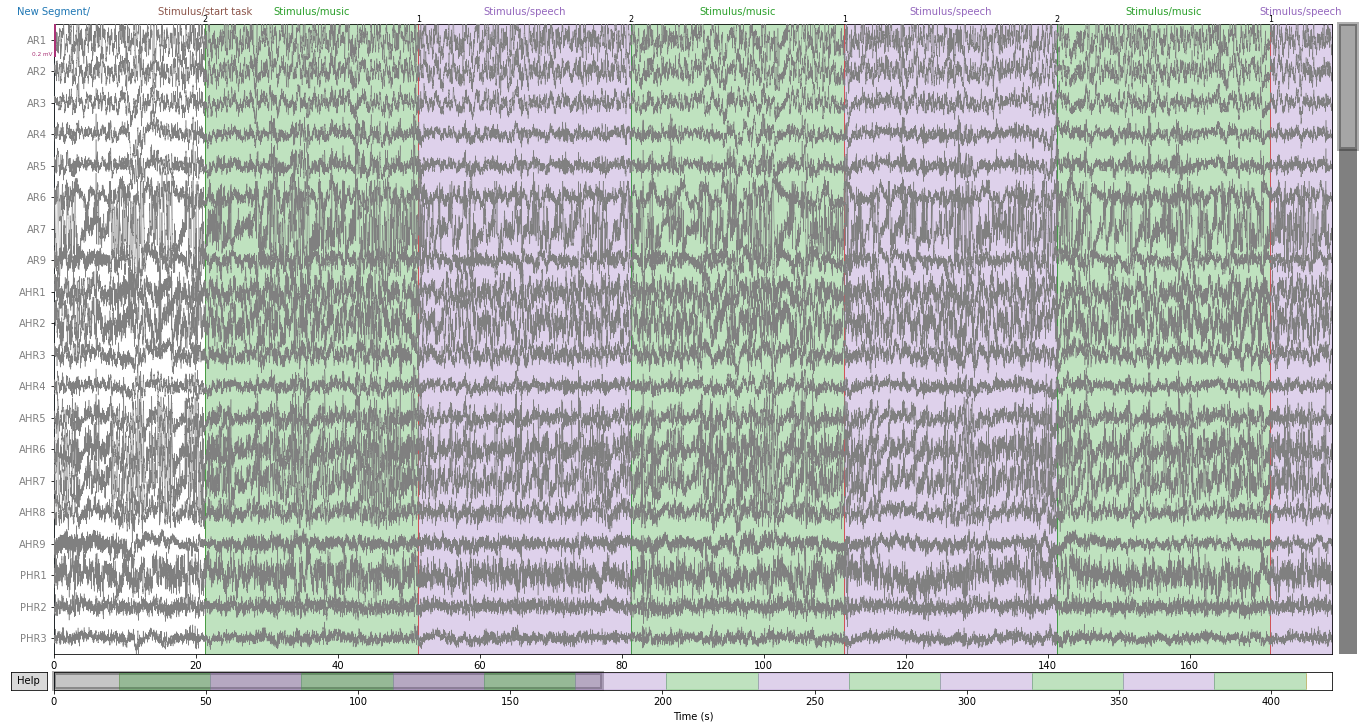

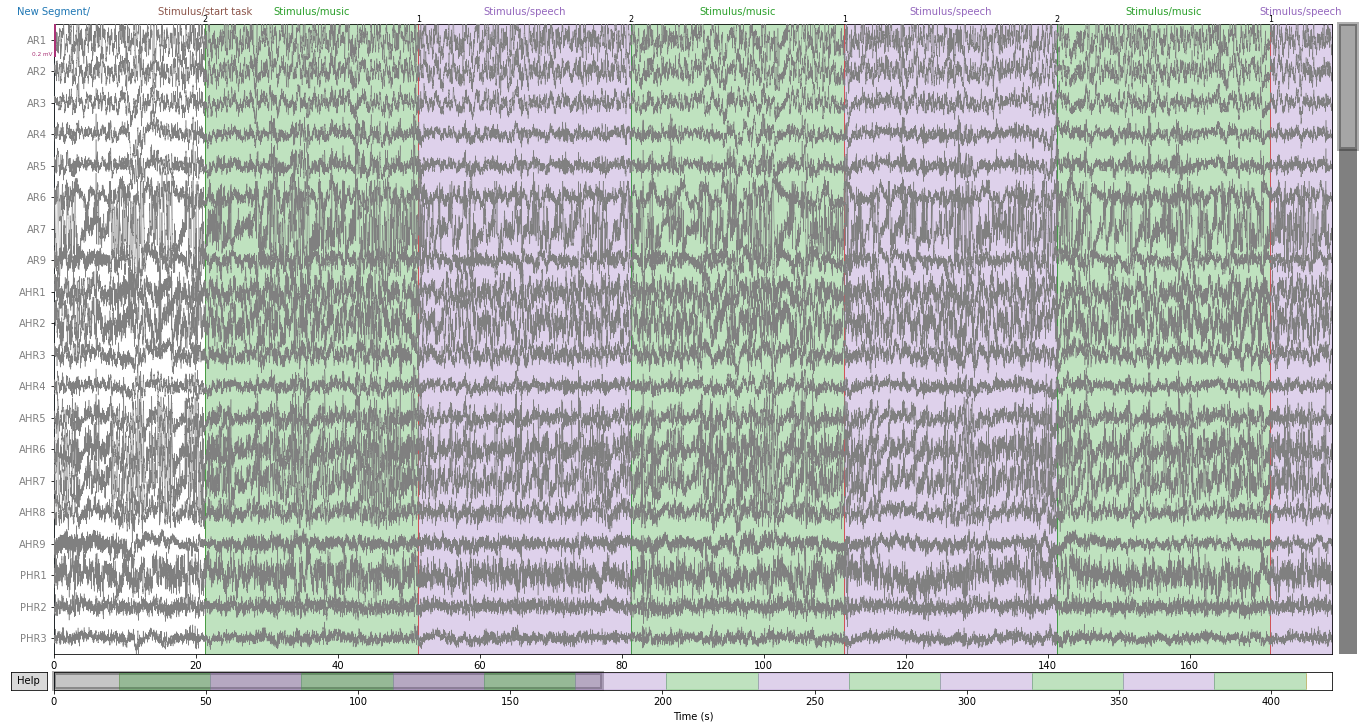

In [13]:
custom_mapping = {'Stimulus/music': 2, 'Stimulus/speech': 1,
                  'Stimulus/end task': 5}  # 'Stimulus/task end' in laan
events, event_id = mne.events_from_annotations(raw_car, event_id=custom_mapping,
                                                         use_rounding=False)

raw_car.plot(events=events, start=0, duration=180, color='gray', event_color={2: 'g', 1: 'r'}, bgcolor='w')

### Crop signal to start and end of the task

In [14]:
gamma_cropped = gamma[events[0, 0]:events[-1, 0]]

### Resample signal to a lower sampling rate

In [15]:
gamma_resampled = resample(gamma_cropped, 25, int(raw.info['sfreq']))